## Setup

In [2]:
#imports
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time
import re
import tensorflow as tf
import tensorflow_hub as hub
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import string
import sys
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed
from datetime import datetime

%matplotlib inline

#set working directory
os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

#load training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')
train_x = twitter_train['Tweet']
train_y = twitter_train['Stance']


#load test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')
test_x = twitter_test['Tweet']
test_y = twitter_test['Stance']

In [3]:
#store the paths to bert & data
local_bert_path =   '/Users/alexdessouky/Desktop/MIDS/w266/bert' 
data_path = '/Users/alexdessouky/Desktop/MIDS/w266/w266_final_project/StanceDataset'  

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

In [4]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 83

W1114 14:25:30.876966 140735964402560 deprecation_wrapper.py:119] From /Users/alexdessouky/Desktop/MIDS/w266/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Bert tokenizer

In [5]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

W1114 14:25:34.139852 140735964402560 deprecation_wrapper.py:119] From /Users/alexdessouky/Desktop/MIDS/w266/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



## Pre-Process Data

In [6]:
#create tokens surrounded by the [CLS] and [SEP] tokens
train_tokens = train_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
test_tokens = test_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])

#mask ids (mask out the paddings)
train_mask_ids = train_tokens.apply(lambda x: len(x)*[1])
test_mask_ids = test_tokens.apply(lambda x: len(x)*[1])

train_mask_ids = train_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                      np.array(x)).tolist()
test_mask_ids = test_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()

#add padding to tokens
train_tokens = train_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
test_tokens = test_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)

#test/train sequence vectors
train_sequenceids = train_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
test_sequenceids = test_tokens.apply(lambda x: np.array(max_length*[0])).tolist()

#convert tokens to sentence ids
train_sentenceids = train_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
test_sentenceids = test_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()

#bert features
bert_train = [np.array(train_sentenceids),np.array(train_mask_ids),np.array(train_sequenceids)]
bert_test = [np.array(test_sentenceids),np.array(test_mask_ids),np.array(test_sequenceids)]

#labels
stance_labels_train = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

stance_labels_test = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

            

#PREP LABELS FOR NN
train_y = np.zeros(shape = (stance_labels_train.shape[0],3))
train_y[stance_labels_train == 0,0] = 1
train_y[stance_labels_train == 1,1] = 1
train_y[stance_labels_train == 2,2] = 1

test_y = np.zeros(shape = (stance_labels_test.shape[0],3))
test_y[stance_labels_test == 0,0] = 1
test_y[stance_labels_test == 1,1] = 1
test_y[stance_labels_test == 2,2] = 1

## Function to obtain a subset of the data

In [7]:
def topic_subset(topic_list):
        
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = twitter_test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #subset labels
    train_y_sub = train_y[matches_train,:]
    test_y_sub = test_y[matches_test,:]
    
    
    #initialize bert training lists for subsetting
    bert_train_sub = []
    bert_test_sub = []
    
    for train_input in bert_train:
        bert_train_sub.append(train_input[matches_train,:])
        
    for test_input in bert_test:
        bert_test_sub.append(test_input[matches_test,:])
        
    #also need to return the test labels in this format for metrics
    true_labels = stance_labels_test[matches_test]
    
    return bert_train_sub, train_y_sub, bert_test_sub, test_y_sub, true_labels

## Functions to Run Metrics

In [8]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    
def metrics(true_labels, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    
    #calculate f1 score
    f1 = f1_score(true_labels, test_predicts, average = 'macro')
    
    print("F1 macro score:", f1)
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

## Custom layer to create Bert

In [9]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
class BertLayer2(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "sequence_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

## Define Model

In [10]:
def bert_model(max_length, train_layers, optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)):
    
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    dropout1= tf.keras.layers.Dropout(rate=0.8)(bert_sequence)
    
    dense1 = tf.keras.layers.Dense(256, activation='relu', name='dense1')(dropout1)
    
    dropout2 = tf.keras.layers.Dropout(rate=0.8)(dense1)
    
    #dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dropout2)
    
    #dropout3 = tf.keras.layers.Dropout(rate=0.5)(dense2)
    
    #dense3 = tf.keras.layers.Dense(16, activation='relu', name='dense3')(dropout3)
    
    #dropout4 = tf.keras.layers.Dropout(rate=0.5)(dense3)
    
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout2)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
def bert_model_2(max_length, train_layers, optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)):
    
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer2(n_fine_tune_layers=train_layers)(bert_inputs)
    
    dropout1= tf.keras.layers.Dropout(rate=0.8)(bert_sequence)
    
    lstm1 = tf.keras.layers.LSTM(83, 
                         #kernel_initializer = keras.initializers.he_normal(),
                         #recurrent_initializer = keras.initializers.he_normal(),
                         #bias_initializer = keras.initializers.he_normal(),
                         dropout = 0.7,
                         name='lstm1')(dropout1)
    
    dense1 = tf.keras.layers.Dense(64, activation='relu', keras.initializers.he_normal(), name='dense1')(lstm1)
    
    dropout2 = tf.keras.layers.Dropout(rate=0.8)(dense1)
    
    
    #dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dropout2)
    
    #dropout3 = tf.keras.layers.Dropout(rate=0.5)(dense2)
    
    #dense3 = tf.keras.layers.Dense(16, activation='relu', name='dense3')(dropout3)
    
    #dropout4 = tf.keras.layers.Dropout(rate=0.5)(dense3)
    
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout2)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## Atheism

In [24]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(["Atheism"])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=12,
    verbose=2,
    batch_size=32,
    class_weight = weights)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_7 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score: 0.6177527129795779
              precision    recall  f1-score   support

     Against       0.91      0.69      0.79       160
        None       0.45      0.75      0.56        28
       Favor       0.41      0.66      0.51        32

   micro avg       0.70      0.70      0.70       220
   macro avg       0.59      0.70      0.62       220
weighted avg       0.78      0.70      0.72       220



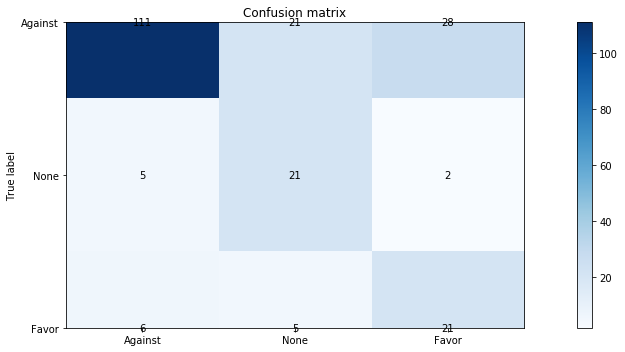

In [25]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

## Hillary Clinton

In [22]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(["Hillary Clinton"])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=12,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score: 0.6788145876361057
              precision    recall  f1-score   support

     Against       0.83      0.72      0.77       172
        None       0.62      0.87      0.73        78
       Favor       0.59      0.49      0.54        45

   micro avg       0.73      0.73      0.73       295
   macro avg       0.68      0.69      0.68       295
weighted avg       0.74      0.73      0.72       295



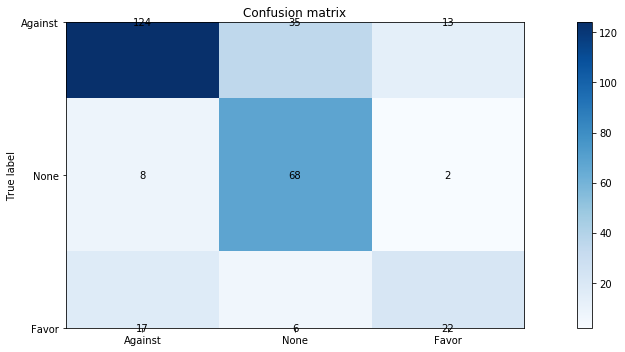

In [23]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

## Abortion

In [29]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=20,
    verbose=2,
    batch_size=32,
    class_weight = weights)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_10 (BertLayer)       (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score: 0.5595024875621891
              precision    recall  f1-score   support

     Against       0.80      0.62      0.70       189
        None       0.44      0.78      0.56        45
       Favor       0.39      0.46      0.42        46

   micro avg       0.62      0.62      0.62       280
   macro avg       0.54      0.62      0.56       280
weighted avg       0.68      0.62      0.63       280



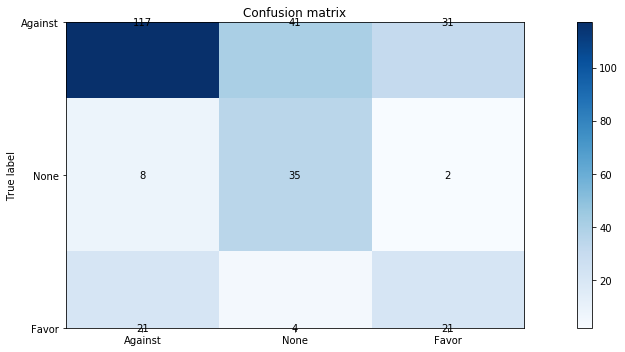

In [30]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

## Climate Change

In [33]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=20,
    verbose=2,
    batch_size=32,
    class_weight = weights)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_12 (BertLayer)       (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score: 0.5221322537112011
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.62      0.80      0.70        35
       Favor       0.86      0.87      0.87       123

   micro avg       0.80      0.80      0.80       169
   macro avg       0.50      0.56      0.52       169
weighted avg       0.76      0.80      0.78       169



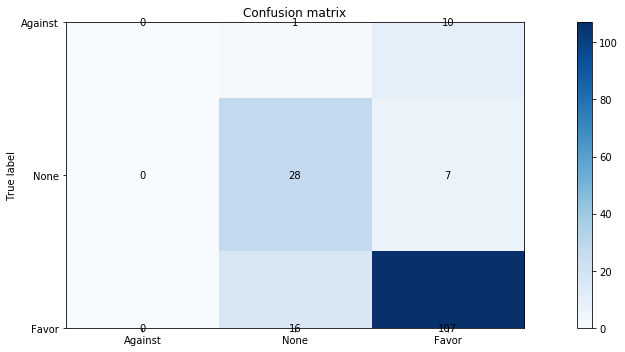

In [34]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

## Feminism

In [14]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=25,
    verbose=2,
    batch_size=32,
    class_weight = weights)

W1114 15:07:14.578288 140735964402560 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score: 0.5047244148717484
              precision    recall  f1-score   support

     Against       0.75      0.51      0.61       183
        None       0.51      0.41      0.46        44
       Favor       0.33      0.71      0.45        58

   micro avg       0.54      0.54      0.54       285
   macro avg       0.53      0.54      0.50       285
weighted avg       0.63      0.54      0.55       285



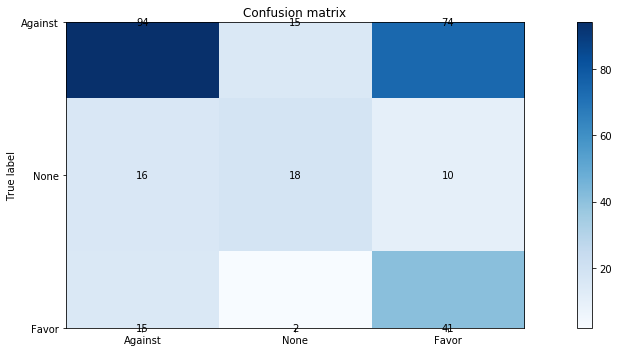

In [15]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)

## ALL

In [17]:
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                             'Atheism',
                                                                             'Feminist Movement'])


#Start session
compute_class = compute_class_weight('balanced', np.unique(true_labels), true_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

model = bert_model(max_length, train_layers=12, optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)


model.fit(
    train_data, 
    train_labels,
    validation_data=[test_data, test_labels],
    epochs=20,
    verbose=1,
    batch_size=32,
    class_weight = weights)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_4 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score: 0.5210482828539095
              precision    recall  f1-score   support

     Against       0.82      0.46      0.59       715
        None       0.33      0.87      0.48       230
       Favor       0.57      0.44      0.50       304

   micro avg       0.53      0.53      0.53      1249
   macro avg       0.57      0.59      0.52      1249
weighted avg       0.67      0.53      0.55      1249



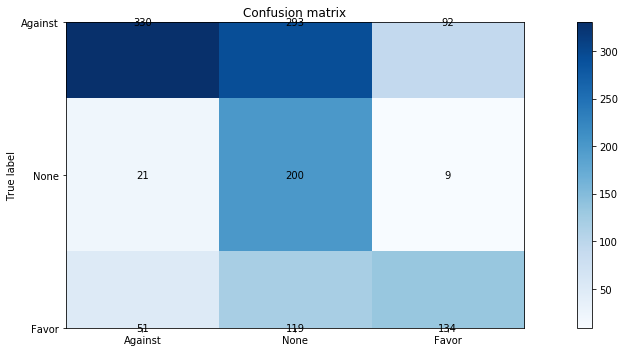

In [18]:
test_probs = model.predict(test_data)
metrics(true_labels, test_probs)